In [86]:
import os
import argparse
import requests
import networkx as nx
import matplotlib.pyplot as plt

In [87]:
API_URL = "https://blockchain.info/rawaddr/1AJbsFZ64EpEfS5UAjAfcUG8pH8Jn3rn1F"  

In [88]:
def fetch_btc_transactions(addr, limit=20):
    try:
        url = API_URL.format(address=addr)
        resp = requests.get(url, params={"limit": max(50, int(limit))}, timeout=25)
        resp.raise_for_status()
        data = resp.json()
    except Exception as e:
        print("[!] fetch failed:", e)
        return []
    txs = data.get("txs", []) or []
    if not txs:
        print("No transactions returned.")
    return txs[:limit]


In [95]:
def tx_to_edges(tx):
    h = tx.get("hash")
    ins = []
    for i in tx.get("inputs", []):
        prev = i.get("prev_out", {}) or {}
        a = prev.get("addr")
        if a:
            ins.append(a)
    outs = []
    for o in tx.get("out", []):
        a2 = o.get("addr")
        if a2:
            outs.append(a2)
    if not ins: 
        ins = ["COINBASE"]
    edges = []
    for s in ins:
        for d in outs:
            edges.append((s, d, h))
    return edges

In [73]:
def build_graph(txs):
    G = nx.DiGraph()
    all_edges = []
    for t in txs:
        all_edges.extend(tx_to_edges(t))
    for s, d, h in all_edges:
        if G.has_edge(s, d):
            G[s][d]["count"] = G[s][d].get("count", 0) + 1
            G[s][d].setdefault("hashes", []).append(h)
        else:
            G.add_edge(s, d, count=1, hashes=[h])
    return G

In [74]:
def plot_wallet_graph(G, out_path="out/task1_graph.png"):
    plt.figure(figsize=(10,8))
    pos = nx.spring_layout(G, seed=42, k=0.6)  # i tweaked k a bit
    nx.draw_networkx_nodes(G, pos, node_size=220)
    nx.draw_networkx_edges(G, pos, arrows=True, arrowstyle="->", arrowsize=10, width=1.1)

In [97]:
deg = dict(G.degree())
if deg:
    top = sorted(deg.items(), key=lambda x: x[1], reverse=True)[:10]
    labels = {n: n for n, _ in top}
    nx.draw_networkx_labels(G, pos, labels=labels, font_size=8)
else:
    print("[i] graph empty, no labels to draw")



[i] graph empty, no labels to draw


In [99]:
plt.title("Wallet Graph (sample of recent tx)")
plt.axis("off")
plt.tight_layout()
plt.savefig(out_path, dpi=200)
plt.close()
print(f"[saved] {out_path}")

[saved] wallet_graph.png


In [100]:
def parse_arguments():
    ap = argparse.ArgumentParser()
    ap.add_argument("--address", required=True, help="BTC address (public)")
    ap.add_argument("--limit", type=int, default=15, help="how many recent tx to sample (10–20 ok)")
    ap.add_argument("--out", default="out/task1_graph.png", help="where to save the image")
    return ap.parse_args()

[i] fetching tx…
nodes: 99 | edges: 112
[i] plotting…


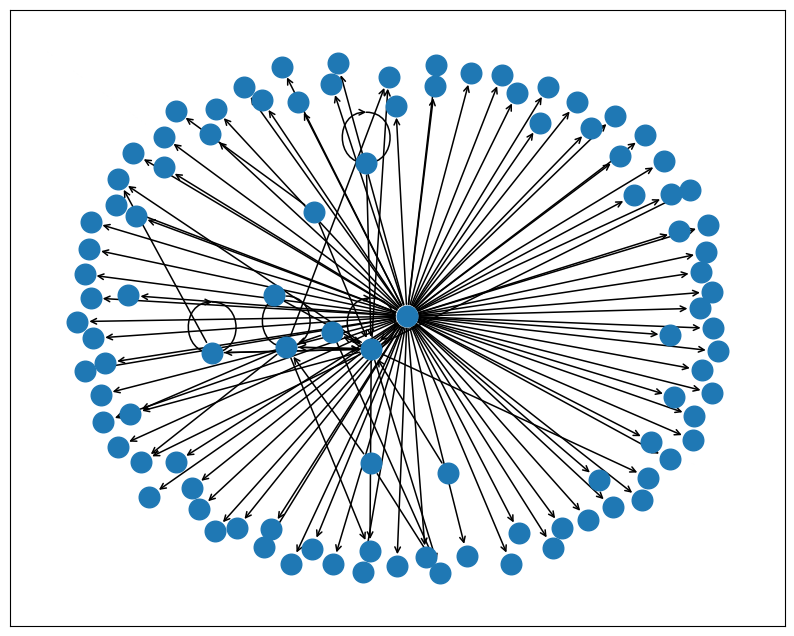

In [108]:
class Args:
    address = "1KFHE7w8BhaENAswwryaoccDb6qcT6DbYY"  # busy BTC address
    limit = 15
    out = "out/task1_graph.png"

args = Args()

print("[i] fetching tx…")
txs = fetch_btc_transactions(args.address, args.limit)
G = build_graph(txs)
print("nodes:", G.number_of_nodes(), "| edges:", G.number_of_edges())
print("[i] plotting…")
plot_wallet_graph(G, args.out)